In [86]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2

In [3]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.layers import Input ,Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, LeakyReLU, Flatten, MaxPooling2D, Dense

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
EPOCHS = 75

In [8]:
df=pd.read_csv("C:\\Users\\sayan\\Downloads\\train (1).csv")

In [71]:
def load_images(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,[64,64])
    img= tf.cast(img, tf.float32)
    img = (img / 127.5)-1

    return img


In [123]:
def crop_image_from_gray(img,tol=7):
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
 
            img = np.stack([img1,img2,img3],axis=-1)

        return img
    
def load_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (64,64))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [124]:
ids = df["id_code"]
labels = df["diagnosis"]

images_folder = "C:\\Users\\sayan\\Downloads\\colored_images\\all" 
image_files = os.listdir(images_folder)


dataset = []
for idx, label in zip(ids, labels):
    image_filename = f"{idx}.png" 
    if image_filename in image_files:
        image_path = os.path.join(images_folder, image_filename)
        image = load_color(image_path)/255.0
        aug_image1 = tf.image.flip_left_right(image)
        aug_image2 = tf.image.rot90(image)
        dataset.append((image, label))
        dataset.append((aug_image1,label))
        dataset.append((aug_image2,label))
        


X=[]
y=[]

for image, label in dataset:

    X.append(image)
    y.append(label)

print('Dataset Made')


Dataset Made


In [125]:
X=np.array(X)
y=np.array(y)

In [126]:
X.shape, y.shape

((10986, 64, 64, 3), (10986,))

Label: 2


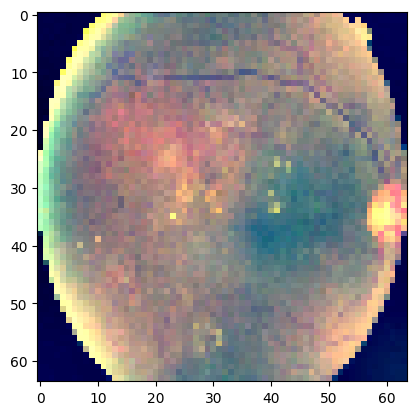

In [130]:

plt.imshow(X[0])
print('Label:',y[0])

In [131]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [132]:
x_val,x_test,y_val,y_test=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

In [133]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((8788, 64, 64, 3),
 (1099, 64, 64, 3),
 (8788,),
 (1099,),
 (1099, 64, 64, 3),
 (1099,))

In [134]:
x_train.dtype

dtype('float64')

In [135]:
y_train.dtype

dtype('int32')

In [140]:
from tensorflow.keras.regularizers import l2

init = tf.keras.initializers.he_uniform()

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [141]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

In [142]:
mod = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/100
550/550 [==============================] - 22s 39ms/step - loss: 2.8350 - accuracy: 0.5633 - val_loss: 2.2499 - val_accuracy: 0.6988
Epoch 2/100
550/550 [==============================] - 20s 37ms/step - loss: 2.3422 - accuracy: 0.6400 - val_loss: 2.1874 - val_accuracy: 0.7125
Epoch 3/100
550/550 [==============================] - 25s 45ms/step - loss: 2.2625 - accuracy: 0.6698 - val_loss: 2.1056 - val_accuracy: 0.7252
Epoch 4/100
550/550 [==============================] - 24s 43ms/step - loss: 2.1795 - accuracy: 0.6899 - val_loss: 2.0324 - val_accuracy: 0.7352
Epoch 5/100
550/550 [==============================] - 25s 46ms/step - loss: 2.1116 - accuracy: 0.7020 - val_loss: 1.9816 - val_accuracy: 0.7325
Epoch 6/100
550/550 [==============================] - 25s 45ms/step - loss: 2.0479 - accuracy: 0.7057 - val_loss: 1.9669 - val_accuracy: 0.7334
Epoch 7/100
550/550 [==============================] - 26s 47ms/step - loss: 1.9832 - accuracy: 0.7142 - val_loss: 1.8975 - val_ac

Text(0, 0.5, 'Accuracy [%]')

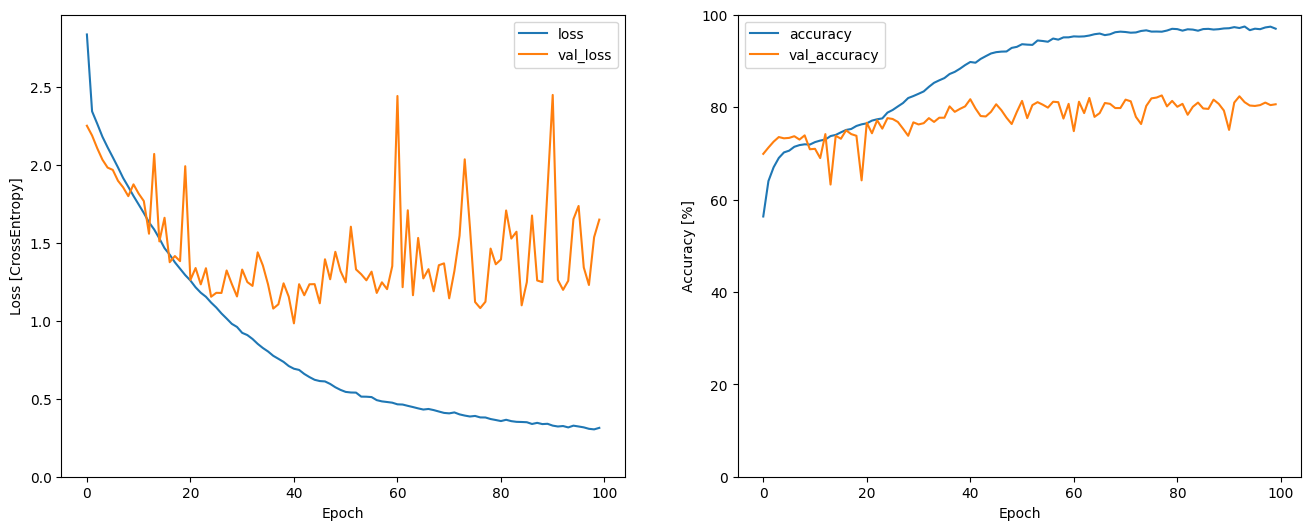

In [143]:
metrics = mod.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(mod.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(mod.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [144]:
import seaborn as sns

344/344 [==============================] - 6s 18ms/step


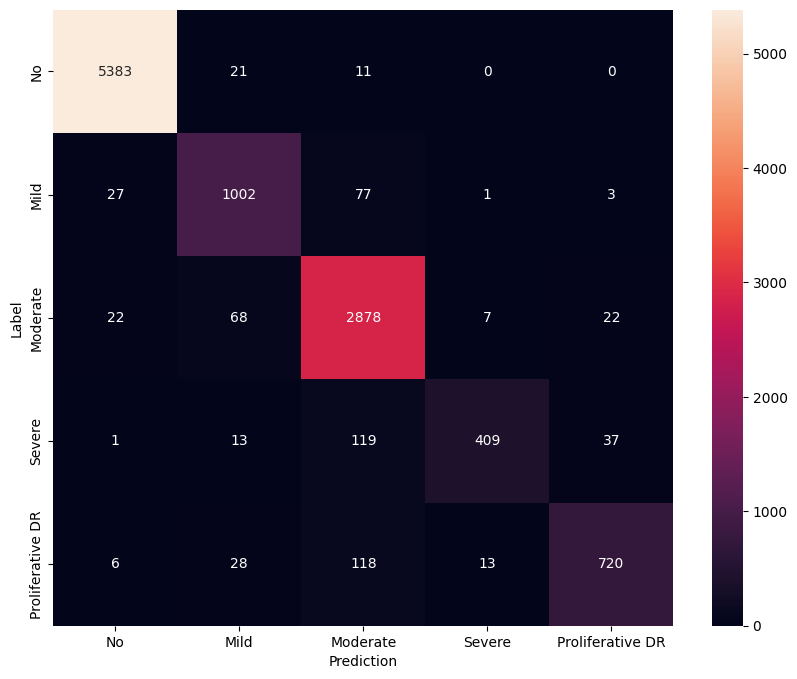

In [148]:
label_list=['No','Mild','Moderate','Severe','Proliferative DR']
y_pred=model.predict(X)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(y, axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [146]:
from sklearn.metrics import classification_report

In [147]:
print('Classification report:')
print(classification_report(y_test,y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       552
           1       0.53      0.56      0.54        98
           2       0.71      0.86      0.78       307
           3       0.68      0.20      0.31        65
           4       0.55      0.34      0.42        77

    accuracy                           0.81      1099
   macro avg       0.69      0.59      0.60      1099
weighted avg       0.81      0.81      0.80      1099



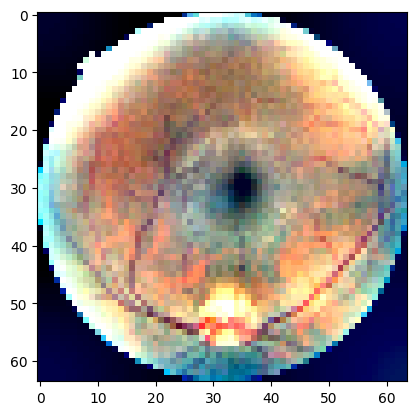

In [149]:
a= X[86]
plt.imshow(a)

In [152]:
b= label_list[np.argmax(model.predict(a[np.newaxis,]))]

1/1 [==============================] - 0s 498ms/step


In [153]:
b

'No'

In [155]:
label_list[y[86]]

'No'